In [1]:
%load_ext autoreload
%autoreload 2
import distance
import pandas as pd
import numpy as np
import data_tables
import interpolation
import age_analysis
import seaborn as sns
from matplotlib import pyplot as plt
import alignment
from IPython.display import display, Markdown
import math
import simulation
from skbio import TreeNode
from skbio.diversity import beta_diversity
import skbio.diversity 
from io import StringIO
import local_dtw
import pcoa as my_pcoa
from skbio.stats.distance import DistanceMatrix
from skbio.stats.ordination import pcoa
from statsmodels.stats import contingency_tables
import random
import scipy
import sklearn
import Config
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from statannot import add_stat_annotation


/home/ranarmoni/anaconda3/envs/MicrobiomeAlignment/lib/python3.6/site-packages/skbio/util/_testing.py:16: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
bangladesh_metadata = pd.read_pickle("./precomputed_data/bangladesh_metadata")
bangladesh_counts = pd.read_pickle("./precomputed_data/bangladesh_counts")
DI_metadata = pd.read_pickle("./precomputed_data/DI_metadata")
DI_counts = pd.read_pickle("./precomputed_data/DI_counts")
bokulich_metadata = pd.read_pickle("./precomputed_data/bokulich_metadata")
bokulich_counts = pd.read_pickle("./precomputed_data/bokulich_counts")

In [3]:
trosvik_counts = pd.read_pickle("./precomputed_data/trosvik_counts")
trosvik_metadata = pd.read_pickle("./precomputed_data/trosvik_metadata")

In [4]:
trosvik_config2 = Config.Config(abundance_threshold = 0.005,max_age = 365,min_max_age=300,window_size = 10,top_predictors_for_age_analysis=0)
trosvik_data = data_tables.ta_data(trosvik_metadata,counts=trosvik_counts,config=trosvik_config2)

warning - abundance dowsn't sum up to 1


In [5]:
trosvik_distance = distance.calculate_bray_curtis_table(trosvik_data.abundance,trosvik_data.abundance)

In [6]:
config2 = Config.Config(abundance_threshold = 0.005,max_age = 365,min_max_age=300,window_size = 10,top_predictors_for_age_analysis=0)
config3 = Config.Config(abundance_threshold = 0.005,max_age = 730,min_max_age=600,window_size = 10,top_predictors_for_age_analysis=0)
basic_config = Config.Config(abundance_threshold = 0.01)

In [ ]:
bangladesh_data = data_tables.ta_data(bangladesh_metadata,counts=bangladesh_counts,config=config3)
DI_data = data_tables.ta_data(DI_metadata,counts=DI_counts,config=config3)
bokulich_data = data_tables.ta_data(bokulich_metadata,counts=bokulich_counts,config=config3)

In [11]:
DI_distance = distance.calculate_bray_curtis_table(DI_data.abundance,DI_data.abundance)    
bokulich_distance = distance.calculate_bray_curtis_table(bokulich_data.abundance,bokulich_data.abundance)    
bangladesh_distance = distance.calculate_bray_curtis_table(bangladesh_data.abundance,bangladesh_data.abundance)    

In [45]:
def early_late_simulation(data,distance_matrix, iterations=100):
    results = np.ndarray(shape=[iterations,3])
    subjects = data.all_subjects()
    for i in range(iterations):
        subject1 = random.choice(subjects)
        subject2 = random.choice(list(set(subjects)-set([subject1])))
        results[i] = calc_early_late_alignmet_scores(subject1,subject2,data,distance_matrix)
    results = pd.DataFrame(results)
    results.columns = ["early-early","late-late","early-late"]
    print("early-early vs. early-late",stats.ttest_ind(results.loc[:,"early-early"], results.loc[:,"early-late"])[1])
    print("early-early vs. late-late",stats.ttest_ind(results.loc[:,"early-early"], results.loc[:,"late-late"])[1])
    print("early-late vs. late-late",stats.ttest_ind(results.loc[:,"early-late"], results.loc[:,"late-late"])[1])



def early_late_simulation_full_dataset(data,distance_matrix, iterations=100):
    subjects = data.all_subjects()
    results = []
    for i,subject1 in enumerate(subjects):
        for subject2 in list(set(subjects)-set([subject1])):
            results += [calc_early_late_alignmet_scores(subject1,subject2,data,distance_matrix)]
    results = pd.DataFrame(results)
    results.columns = ["early-early","late-late","early-late"]
    print("early-early vs. early-late",stats.mannwhitneyu(results.loc[:,"early-early"], results.loc[:,"early-late"])[1])
    print("early-early vs. late-late",stats.mannwhitneyu(results.loc[:,"early-early"], results.loc[:,"late-late"])[1])
    print("early-late vs. late-late",stats.mannwhitneyu(results.loc[:,"early-late"], results.loc[:,"late-late"])[1])
#     results.boxplot()
#     plt.show()
    return pd.DataFrame(results)
        

def calc_early_late_alignmet_scores(subject1,subject2,data,distance_matrix):
    early_samples_1, late_samples_1 = split_early_late(subject1, data)
    early_samples_2, late_samples_2 = split_early_late(subject2, data)
    early_early = alignment.align(x=None,y=None,distance_matrix=distance_matrix.loc[early_samples_1,early_samples_2],how="global",threshold=0).normalizedDistance
    early_late = alignment.align(x=None,y=None,distance_matrix=distance_matrix.loc[early_samples_1,late_samples_2],how="global",threshold=0).normalizedDistance
    late_late = alignment.align(x=None,y=None,distance_matrix=distance_matrix.loc[late_samples_1,late_samples_2],how="global",threshold=0).normalizedDistance
    return early_early, late_late, early_late

def split_early_late(subject1, data):
    all_samples = data.ages[data.ages["Subject_ID"]==subject1].sort_values(by="Age_at_Collection")
    half = all_samples.shape[0]//2
    early = list(all_samples[:half]["SampleID"].values)
    late = list(all_samples[half:]["SampleID"].values)
    
    
    return early, late



In [65]:
results1 = early_late_simulation_full_dataset(bokulich_data,pd.DataFrame(bokulich_distance))
results2 = early_late_simulation_full_dataset(trosvik_data,pd.DataFrame(trosvik_distance))
results3 = early_late_simulation_full_dataset(bangladesh_data,bangladesh_distance)
results4 = early_late_simulation_full_dataset(DI_data,pd.DataFrame(DI_distance))




early-early vs. early-late 7.177100083618689e-117
early-early vs. late-late 7.938879232254074e-13
early-late vs. late-late 2.3201257424603512e-53
early-early vs. early-late 2.120074407793166e-05
early-early vs. late-late 0.0005917601961497548
early-late vs. late-late 0.1826777095826611
early-early vs. early-late 8.648896877311565e-232
early-early vs. late-late 1.6152152052724846e-293
early-late vs. late-late 1.1427224827251536e-09
early-early vs. early-late 4.3830067004203743e-44
early-early vs. late-late 1.1088628466658532e-06
early-late vs. late-late 2.905242055500047e-87


In [66]:
results1["dataset"]="bokulich"
results2["dataset"]="trosvik"
results3["dataset"]="bangladesh"
results4["dataset"]="DI"
merged = pd.concat([results1,results2,results3,results4])
merged_early_early = merged.copy()
merged_early_early=merged_early_early.loc[:,["early-early","dataset"]]
merged_early_early.columns=["score","dataset"]
merged_early_early["kind"]="early-early"

merged_late_late = merged.copy()
merged_late_late=merged_late_late.loc[:,["late-late","dataset"]]
merged_late_late.columns=["score","dataset"]
merged_late_late["kind"]="late-late"


merged_early_late = merged.copy()
merged_early_late=merged_early_late.loc[:,["early-late","dataset"]]
merged_early_late.columns=["score","dataset"]
merged_early_late["kind"]="early-late"

merged_new = pd.concat([merged_early_early,merged_late_late,merged_early_late])




Text(86.375, 0.5, 'Mean score')

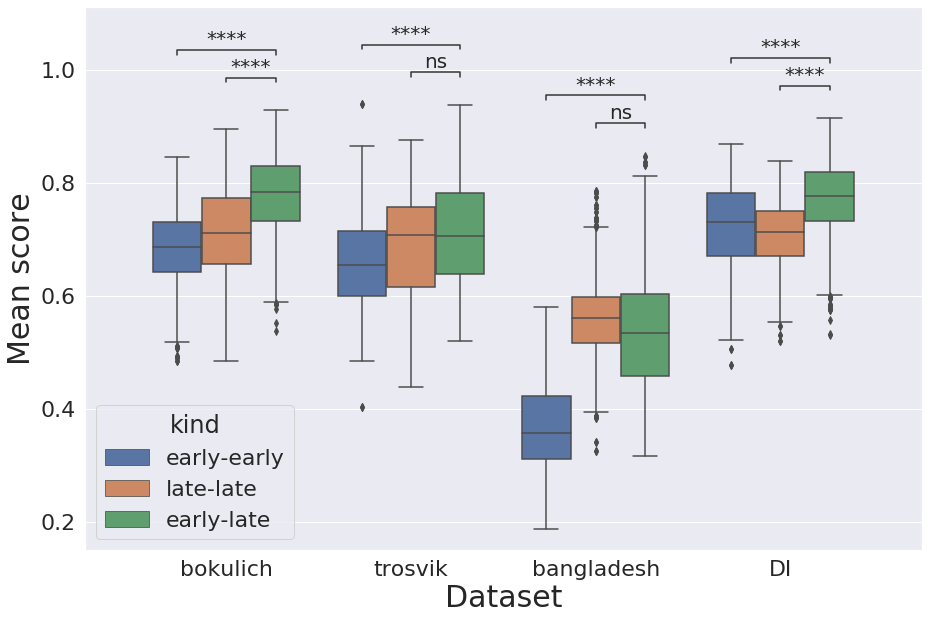

In [68]:
plt.style.use('ggplot')
plt.figure(figsize = (15,10))
sns.set(font_scale=2)
ax = sns.boxplot(y='score', x='dataset', 
                 data=merged_new, 
                 hue='kind')
add_stat_annotation(ax,data = merged_new,y='score', x='dataset',hue="kind",
                    perform_stat_test=True,test="Mann-Whitney-ls",box_pairs=[(("bokulich","early-early"),("bokulich","early-late")),(("bokulich","early-late"),("bokulich","late-late")),
                                                                         (("trosvik","early-early"),("trosvik","early-late")),(("trosvik","early-late"),("trosvik","late-late")),
                                                                         (("DI","early-early"),("DI","early-late")),(("DI","early-late"),("DI","late-late")),
                                                                         (("bangladesh","early-early"),("bangladesh","early-late")),(("bangladesh","early-late"),("bangladesh","late-late"))],
                                    text_format='star',comparisons_correction=None,
                                   loc='inside', verbose=0,fontsize=20,linewidth=1.5,line_height=0.01,line_offset=0.01,)

ax.set_xlabel('Dataset', fontsize=30)
ax.set_ylabel('Mean score', fontsize=30)   # relative to plt.rcParams['font.size']

## shuffle simulation

In [52]:
def shuffle_samples(data):
    new_data = data.copy()
    original_sample_ids = list(data.abundance.columns)
    new_data.abundance = new_data.abundance.loc[:,np.random.permutation(original_sample_ids)]
    new_data.abundance.columns = original_sample_ids
    return new_data


def shuffle_distance(original_distance):
    new_distance = original_distance.copy()
    new_distance = new_distance.loc[np.random.permutation(original_distance.index),np.random.permutation(original_distance.columns)]
    
    return new_distance
    

In [53]:
def shuffle_simulation(data,distance_matrix_original, iterations=100):
    results = np.ndarray(shape=[iterations,2])
    subjects = data.all_subjects()
    for i in range(iterations):
        subject1 = random.choice(subjects)
        subject2 = random.choice(list(set(subjects)-set([subject1])))
        samples1, samples2 = data.sample_ids_by_subject(subject1), data.sample_ids_by_subject(subject2)
        results[i,0] = alignment.align(x=None,y=None,distance_matrix=distance_matrix_original.loc[samples1,samples2],how="global",threshold=0).normalizedDistance
        results[i,1] = alignment.align(x=None,y=None,distance_matrix=shuffle_distance(distance_matrix_original.loc[samples1,samples2]),how="global",threshold=0).normalizedDistance
    results = pd.DataFrame(results)
    results.columns = ["normal","shuffled"]
    print("early-early vs. early-late",stats.ttest_ind(results.loc[:,"normal"], results.loc[:,"shuffled"])[1])
    results.boxplot()
    plt.show()
    
    
    return results


def shuffle_simulation_full_dataset(data,distance_matrix_original):
    subjects = data.all_subjects()
    results_normal = [] 
    results_shuffled = [] 
    for i,subject1 in enumerate(subjects):
        for subject2 in subjects[i+1:]:
            samples1, samples2 = list(data.sample_ids_by_subject(subject1)), list(data.sample_ids_by_subject(subject2))
            results_normal += [alignment.align(x=None,y=None,distance_matrix=distance_matrix_original.loc[samples1,samples2],how="global",threshold=0).normalizedDistance]
            results_shuffled += [alignment.align(x=None,y=None,distance_matrix=shuffle_distance(distance_matrix_original.loc[samples1,samples2]),how="global",threshold=0).normalizedDistance]
    results = pd.DataFrame([results_normal,results_shuffled]).T
    results.columns = ["normal","shuffled"]
    print("normal vs. shuffled",stats.mannwhitneyu(results.loc[:,"normal"], results.loc[:,"shuffled"])[0])
    print("normal vs. shuffled",stats.mannwhitneyu(results.loc[:,"normal"], results.loc[:,"shuffled"])[1])
    results.boxplot()
    plt.show()    
    
    return results



normal vs. shuffled 45722.0
normal vs. shuffled 5.3247829283424655e-18


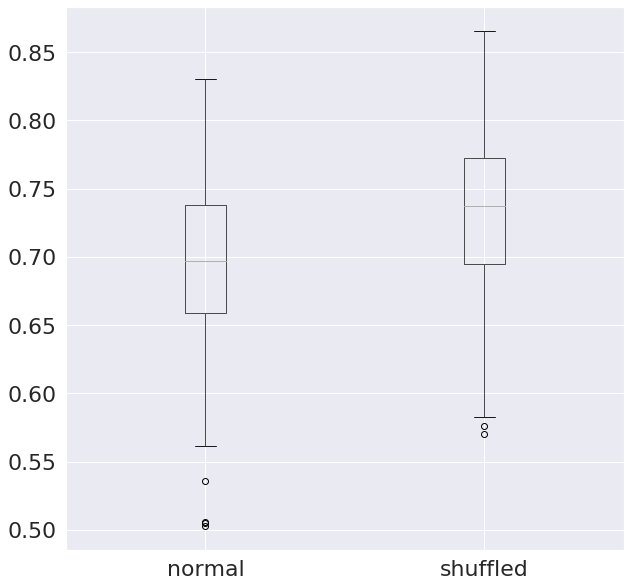

normal vs. shuffled 1657.0
normal vs. shuffled 0.008921212796155414


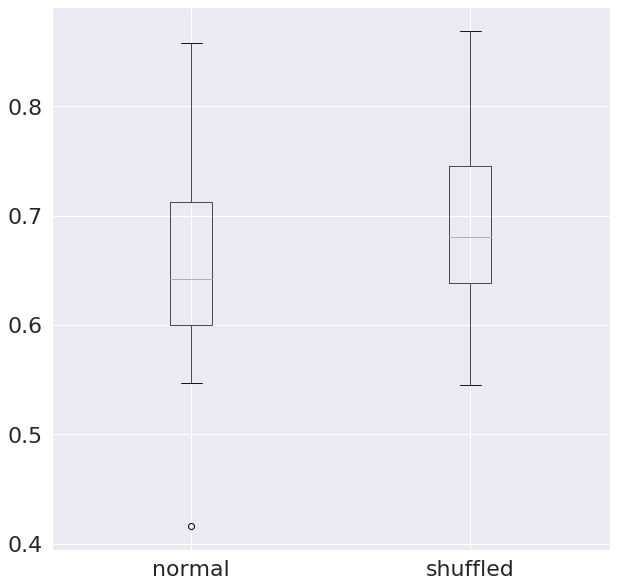

normal vs. shuffled 92931.0
normal vs. shuffled 3.43634610471069e-21


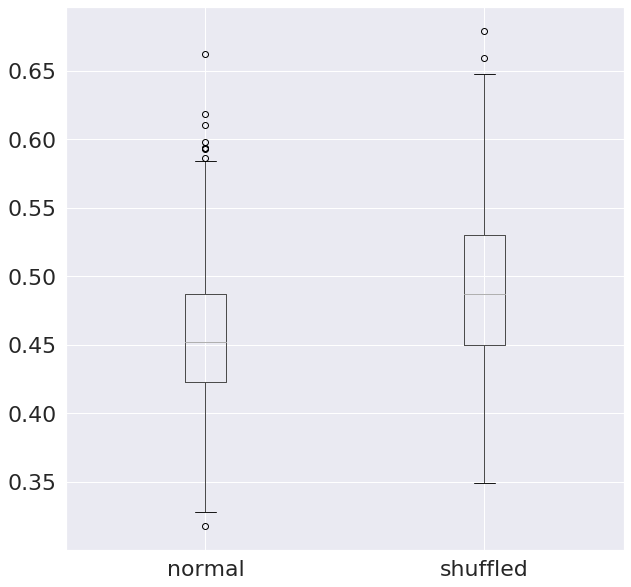

normal vs. shuffled 82329.0
normal vs. shuffled 1.5369211970724416e-10


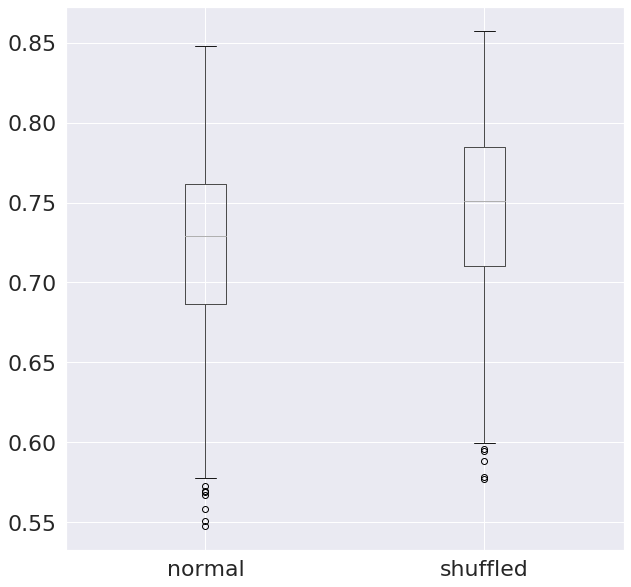

In [54]:
results1 = shuffle_simulation_full_dataset(bokulich_data,pd.DataFrame(bokulich_distance))
results2 = shuffle_simulation_full_dataset(trosvik_data,pd.DataFrame(trosvik_distance))
results3 = shuffle_simulation_full_dataset(bangladesh_data,bangladesh_distance)
results4 = shuffle_simulation_full_dataset(DI_data,pd.DataFrame(DI_distance))


In [55]:
results1["dataset"]="bokulich"
results2["dataset"]="trosvik"
results3["dataset"]="bangladesh"
results4["dataset"]="DI"
merged = pd.concat([results1,results2,results3,results4])
merged_normal = merged.copy()
merged_normal=merged_normal.loc[:,["normal","dataset"]]
merged_normal.columns=["score","dataset"]
merged_normal["kind"]="normal"
merged_shuffled = merged.copy()
merged_shuffled=merged_shuffled.loc[:,["shuffled","dataset"]]
merged_shuffled.columns=["score","dataset"]
merged_shuffled["kind"]="shuffled"
merged_new = pd.concat([merged_normal,merged_shuffled])


Text(86.375, 0.5, 'Mean score')

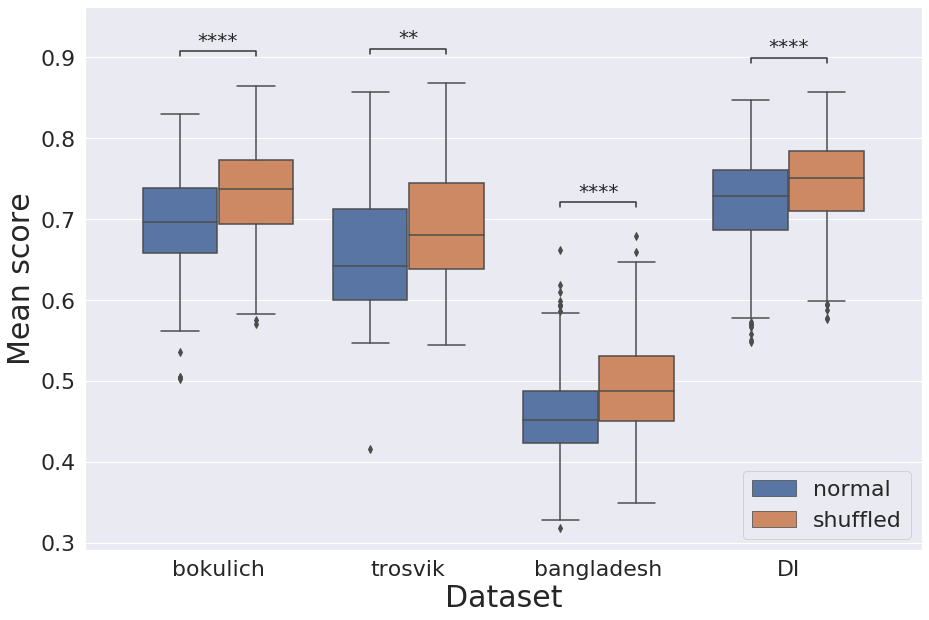

In [63]:
plt.figure(figsize = (15,10))
sns.set(font_scale=2)
ax = sns.boxplot(y='score', x='dataset', 
                 data=merged_new, 
                 hue='kind')
plt.legend(loc='lower right')

add_stat_annotation(ax,data = merged_new,y='score', x='dataset',hue="kind",
                    perform_stat_test=True,test="Mann-Whitney-ls",box_pairs=[(("bokulich","normal"),("bokulich","shuffled")),(("bangladesh","normal"),("bangladesh","shuffled")),(("DI","normal"),("DI","shuffled")),(("trosvik","normal"),("trosvik","shuffled"))],
                                    text_format='star',comparisons_correction=None,
                                   loc='inside', verbose=0,fontsize=20,linewidth=1.5,line_height=0.01,line_offset=0.01,)
ax.set_xlabel('Dataset', fontsize=30)
ax.set_ylabel('Mean score', fontsize=30)   # relative to plt.rcParams['font.size']
